In [1]:
import numpy as np # para criar a MLP
import matplotlib.pyplot as plt # plotar a curva de custo
from scipy.stats import randint, rv_discrete, uniform # para o random search

In [ ]:
class MLP:
    """
    Classe que fiz para implementação da MLP (Perceptron Multicamadas), para
    regressão e classificação (multinomial). A principal diferença entre os dois modos está nas funções de ativação
    utilizadas e na forma de inicialização dos pesos. Eu utilizei a função ReLU para classificação e tanh
    para regressão.

    Eu construí a rede para ter uma única camada oculta, pois essa configuração foi pedida para 
    as questões. A classe recebe os dados de treino e teste, sendo que os dados de teste são
    utilizados apenas para o acompanhamento visual da função de custo ao longo das épocas.

    A classe inclui hiperparâmetros:
    learning_rate: taxa de aprendizado.
    momentum: fator de momento para atualização dos pesos.
    epochs: número total de épocas de treinamento.
    batch_size: tamanho do mini-batch.
    lambda_l2: coeficiente de regularização L2.
    scheduler_learning_rate: possibilidade de ajuste dinâmico da taxa de aprendizado
       (embora, na prática, essa funcionalidade não tenha se mostrado positiva nos testes que realizei).
    eval: ativa o print() dos resultados ao final de cada época.
    seed: reprodução dos resultados.

    A classe também armazena o histórico do custo durante o treinamento.
    """

    def __init__(
        self,
        X,
        y,
        X_teste,
        y_teste,
        mode="Regression",
        hidden_size=100,
        learning_rate=0.1,
        momentum=0,
        epochs=1000,
        batch_size=16,
        lambda_l2=0,
        scheduler_learning_rate=None,
        eval=True,
        seed=2,
    ):
        self.historico_custo = []
        self.X = X
        self.y = y
        self.X_teste = X_teste
        self.y_teste = y_teste
        self.mode = mode
        self.epochs = epochs
        self.batch_size = batch_size
        self.lambda_l2 = lambda_l2
        self.scheduler_learning_rate = scheduler_learning_rate
        self.eval = eval

        input_size = self.X.shape[1]

        self.random_1 = np.random.default_rng(seed)
        self.random_2 = np.random.default_rng(seed + 1)
        
        # Como comentei o tipo de inicialização dos pesos depende do tipo do problema. 
        # Usei as inicialização aleatória baseada em heurísticas
        if mode == "Regression":
            output_size = 1
            self.W1 = self.random_1.normal(size=(input_size, hidden_size)) * np.sqrt(
                1 / input_size
            )
            self.b1 = np.zeros((1, hidden_size))
            self.W2 = self.random_2.normal(size=(hidden_size, output_size)) * np.sqrt(
                1 / hidden_size
            )
            self.b2 = np.zeros((1, output_size))
        elif self.mode == "Classification":
            output_size = len(np.unique(self.y))
            self.W1 = self.random_1.normal(size=(input_size, hidden_size)) * np.sqrt(
                2 / input_size
            )
            self.b1 = np.zeros((1, hidden_size)) + 0.01
            self.W2 = self.random_2.normal(size=(hidden_size, output_size)) * np.sqrt(
                2 / hidden_size
            )
            self.b2 = np.zeros((1, output_size)) + 0.01

        self.base_learning_rate = learning_rate
        self.momentum = momentum

        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        cross_entropy_loss = -np.log(y_pred[range(m), y_true] + 1e-8).mean()
        return cross_entropy_loss

    def mse(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2) / 2

    def activation_function(self, Z):
        if self.mode == "Regression":
            return self.tanh(Z)
        elif self.mode == "Classification":
            return self.relu(Z)

    def activation_function_derivate(self, Z):
        if self.mode == "Regression":
            return self.tanh_derivative(Z)
        elif self.mode == "Classification":
            return self.relu_derivative(Z)

    def output_function(self, Z):
        if self.mode == "Regression":
            return Z
        elif self.mode == "Classification":
            return self.softmax(Z)

    def cost_function(self, y_pred, y_true):
        if self.mode == "Regression":
            return self.mse(y_pred, y_true)
        elif self.mode == "Classification":
            return self.cross_entropy_loss(y_pred, y_true)

    def forward(self, X):
        self.U = X @ self.W1 + self.b1
        self.Z = self.activation_function(self.U)
        self.R = self.Z @ self.W2 + self.b2
        return self.output_function(self.R)

    def backward(self, X, y, y_pred):
        m = X.shape[0]

        if self.mode == "Regression":
            delta = (y_pred - y) / m
        elif self.mode == "Classification":
            delta = y_pred.copy()
            delta[range(m), y] -= 1
            delta /= m

        teta = (delta @ self.W2.T) * self.activation_function_derivate(self.U)

        dW2 = self.Z.T @ delta
        dW1 = X.T @ teta
        db2 = np.sum(delta, axis=0, keepdims=True)
        db1 = np.sum(teta, axis=0, keepdims=True)

        dW2 += self.lambda_l2 * self.W2 / m
        dW1 += self.lambda_l2 * self.W1 / m

        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2):
        self.v_W2 = self.momentum * self.v_W2 - self.learning_rate * dW2
        self.v_b2 = self.momentum * self.v_b2 - self.learning_rate * db2
        self.v_W1 = self.momentum * self.v_W1 - self.learning_rate * dW1
        self.v_b1 = self.momentum * self.v_b1 - self.learning_rate * db1

        self.W2 += self.v_W2
        self.b2 += self.v_b2
        self.W1 += self.v_W1
        self.b1 += self.v_b1

    def update_learning_rate(self, epoch):
        if self.scheduler_learning_rate == "exponencial":
            self.learning_rate = self.base_learning_rate / (1 + epoch)
        elif self.scheduler_learning_rate == "linear":
            self.learning_rate = self.base_learning_rate * (1 - epoch / self.epochs)
        else:
            self.learning_rate = self.base_learning_rate

    def train(self):
        self.historico_custo = []
        n = self.X.shape[0]
        melhor_loss_test = float("inf")
        paciencia = 0
        tolerancia = 30
        delta_tolerancia = 1e-6

        for epoch in range(1, self.epochs + 1):
            permutation = self.random_1.permutation(n)
            X_shuffled = self.X[permutation]
            y_shuffled = self.y[permutation]

            for i in range(0, n, self.batch_size):
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]

                y_pred = self.forward(X_batch)
                dW1, db1, dW2, db2 = self.backward(X_batch, y_batch, y_pred)

                self.update_learning_rate(epoch)
                self.update_weights(dW1, db1, dW2, db2)

            y_pred_train = self.forward(self.X)
            y_pred_test = self.forward(self.X_teste)

            loss_train = self.cost_function(y_pred_train, self.y)
            loss_test = self.cost_function(y_pred_test, self.y_teste)

            self.historico_custo.append((epoch, loss_train, loss_test))

            if self.eval:
                print(
                    f"Epoch {epoch}/{self.epochs} - Loss: {loss_train:.4f} | Val Loss: {loss_test:.4f}"
                )

            if melhor_loss_test - loss_test >= delta_tolerancia:
                melhor_loss_test = loss_test
                paciencia = 0
            else:
                paciencia += 1
                if paciencia >= tolerancia:
                    if self.eval:
                        print(
                            f"Parando antecipadamente: sem melhora em {tolerancia} épocas consecutivas."
                        )
                    break

    def predict(self, X):
        y_pred = self.forward(X)
        if self.mode == "Regression":
            return y_pred
        elif self.mode == "Classification":
            return np.argmax(y_pred, axis=1)

In [3]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self, X):
        return X * self.std + self.mean

In [4]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    random_seed = np.random.default_rng(seed=random_state)
    size_data = X.shape[0]
    id_random = random_seed.permutation(size_data)
    tamanho_treino = int((1 - test_size) * size_data)
    id_treino = id_random[:tamanho_treino]
    id_teste = id_random[tamanho_treino:]
    return X[id_treino, :], X[id_teste, :], y[id_treino, :], y[id_teste, :]

In [5]:
class RandomSearchMLP:
    """
    Classe que fiz para realizar uma busca aleatória (Random Search) de hiperparâmetros
    para o MLP.

    A busca é feita com base em duas categorias de parâmetros:
    - parameters_distributions: dicionário contendo os hiperparâmetros que devem ser
      amostrados aleatoriamente, cada um associado a uma distribuição.
    - parameters_other: dicionário com os parâmetros fixos que permanecem constantes durante os testes.

    A cada repetição da busca (controlada por repeats), um novo conjunto de hiperparâmetros é
    amostrado, o modelo é treinado e o desempenho é registrado com base no erro de validação.
    Ao final, os melhores parâmetros (com menor erro de validação) são armazenados em best_params.
    """

    def __init__(
        self,
        X_train,
        y_train,
        X_validation,
        y_validation,
        MLP,
        parameters_distributions=None,
        parameters_other=None,
        repeats=10,
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.model = MLP
        self.parameters_distributions = parameters_distributions
        self.parameters_other = parameters_other
        self.repeats = repeats
        self.results = []
        self.best_params = None

    def search(self):
        self.results = []

        for repeat in range(self.repeats):
            parametros_random = {
                key: value.rvs(size=1, random_state=repeat).item()
                for key, value in self.parameters_distributions.items()
            }
            parametros = parametros_random | self.parameters_other
            model = self.model(
                self.X_train,
                self.y_train,
                self.X_validation,
                self.y_validation,
                **parametros,
            )
            model.train()
            _, _, er_test = zip(*model.historico_custo)
            self.results.append((parametros_random, model.historico_custo, er_test[-1]))

        test_loss = [x[2] for x in self.results]
        arg_min_test = np.argmin(test_loss)
        self.best_params = self.results[arg_min_test]

In [6]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat) ** 2))


def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))


def mre(y, y_hat, eps=1e-8):
    return np.mean(np.abs((y - y_hat) / (y + eps)))

In [7]:
def calc_acuracia_global(y, y_hat):
    """
    Calcular a acurácia global
    """
    return np.mean(y == y_hat)

def matriz_confusao(y, y_hat):
    """
    Calcular a matriz de confusão
    """
    classes = np.unique(y)
    n_classes = len(classes)
    matriz = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            matriz[i, j] = np.sum((y == true_class) & (y_hat == pred_class))
    return matriz

# Questão 1 
Considere o conjunto de dados disponível em `concrete.csv`, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascal, MPa). Maiores detalhes sobre os dados podem ser conferidos em: [https://www.openml.org/d/4353](https://www.openml.org/d/4353).

## a) Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

– **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em *minibatch* via gradiente descendente estocástico com termo de *momentum*. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [8]:
concrete = np.loadtxt("concrete.csv", delimiter=',')

In [9]:
concrete.shape

(1030, 9)

In [10]:
X = concrete[:,0:8]

In [11]:
y = concrete[:,8].reshape(-1,1)

In [12]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42)

In [14]:
x_scaler = StandardScaler()
X_train_standard = x_scaler.fit_transform(X_train)

In [15]:
y_scaler = StandardScaler()
y_train_standard = y_scaler.fit_transform(y_train)

In [16]:
X_validation_standard = x_scaler.transform(X_validation)

In [17]:
y_validation_standard = y_scaler.transform(y_validation)

In [18]:
X_test_standard = x_scaler.transform(X_test)
y_test_standard = y_scaler.transform(y_test)

In [19]:
parametros_dist = {
    "hidden_size": randint(10, 300),
    "learning_rate": rv_discrete(
        name="learning_rate",
        values=([10**e for e in [-5, -4, -3, -2]], [1 / 4] * 4),
    ),
    "momentum": uniform(0.5,0.5),
    "batch_size": rv_discrete(name="batch_size", values=([16, 32, 64, 128], [1 / 4] * 4)),
    "lambda_l2": rv_discrete(
        name="lambda_l2", values=([10**e for e in [-5, -3, -1, 0]], [1 / 4] * 4)
    ),
}

In [20]:
parametros = {
    "mode": "Regression",
    "epochs": 2000,
    "eval": False,
    "seed": 2,
}

In [21]:
random_search = RandomSearchMLP(
    X_train_standard,
    y_train_standard,
    X_validation_standard,
    y_validation_standard,
    MLP,
    parameters_distributions=parametros_dist,
    parameters_other=parametros,
    repeats=100
)

In [22]:
random_search.search()

In [24]:
best_parametros = random_search.best_params

In [25]:
best_parametros[0]

{'hidden_size': 143,
 'learning_rate': 0.001,
 'momentum': 0.8642535957978628,
 'batch_size': 64,
 'lambda_l2': 0.1}

## b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:

- **RMSE (root mean squared error)**:

  $$
  \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
  $$

- **MAE (mean absolute error)**:

  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
  $$

- **MRE (mean relative error)**:

  $$
  \text{MRE} = \frac{1}{N} \sum_{i=1}^{N} \frac{y_i - \hat{y}_i}{y_i}
  $$

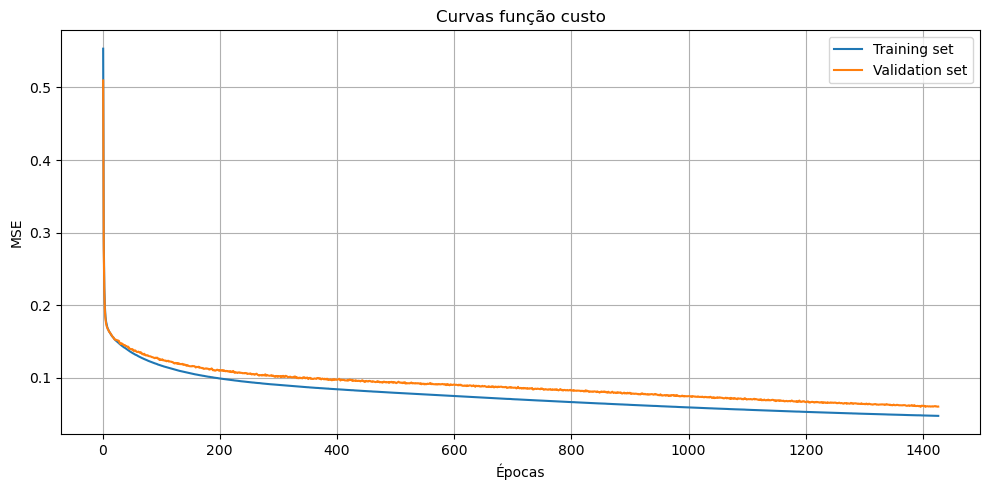

In [26]:
ep, er, er_test = zip(*best_parametros[1])
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curvas função custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Treinei novamente para pegar o melhor modelo com base no random search

parametros = best_parametros[0] | parametros

model = MLP(
    X_train_standard,
    y_train_standard,
    X_validation_standard,
    y_validation_standard,
    **parametros,
)

model.train()

In [28]:
y_hat_standard = model.predict(X_train_standard)
y_hat = y_scaler.inverse(y_hat_standard)

train_rmse = rmse(y_train, y_hat)
train_mae = mae(y_train, y_hat)
train_mre = mre(y_train, y_hat)

In [29]:
y_hat_standard = model.predict(X_validation_standard)
y_hat = y_scaler.inverse(y_hat_standard)

validacao_rmse = rmse(y_validation, y_hat)
validacao_mae = mae(y_validation, y_hat)
validacao_mre = mre(y_validation, y_hat)

In [30]:
y_hat_standard = model.predict(X_test_standard)
y_hat = y_scaler.inverse(y_hat_standard)

test_rmse = rmse(y_test, y_hat)
test_mae = mae(y_test, y_hat)
test_mre = mre(y_test, y_hat)

In [31]:
print("Resultados do Treino:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE : {train_mae:.2f}")
print(f"  MRE : {train_mre:.2%}") 

print("Resultados da Validação:")
print(f"  RMSE: {validacao_rmse:.2f}")
print(f"  MAE : {validacao_mae:.2f}")
print(f"  MRE : {validacao_mre:.2%}") 

print("Resultados do Teste:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE : {test_mae:.2f}")
print(f"  MRE : {test_mre:.2%}")

Resultados do Treino:
  RMSE: 5.24
  MAE : 4.06
  MRE : 13.97%
Resultados da Validação:
  RMSE: 5.90
  MAE : 4.47
  MRE : 15.16%
Resultados do Teste:
  RMSE: 6.21
  MAE : 4.80
  MRE : 17.73%


# Questão 2

Considere o conjunto de dados disponível em `vowel.csv`, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em: [https://www.openml.org/d/307](https://www.openml.org/d/307).

## a) Considere um modelo de classificação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:

– **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em *minibatch* via gradiente descendente estocástico com termo de *momentum*. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [32]:
from sklearn.model_selection import train_test_split # eu não usei o que eu fiz, pois achei melhor usar um que tem stratify

In [33]:
vowel = np.loadtxt("vowel.csv", delimiter=',')

In [34]:
vowel.shape

(990, 11)

In [35]:
X = vowel[:,0:10]

In [36]:
y = vowel[:,10].astype(int)

In [37]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [38]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_validation,
    y_train_validation,
    test_size=0.2,
    random_state=1,
    stratify=y_train_validation,
)

In [39]:
x_scaler = StandardScaler()
X_train_standard = x_scaler.fit_transform(X_train)

In [40]:
X_validation_standard = x_scaler.transform(X_validation)

In [41]:
X_test_standard = x_scaler.transform(X_test)

In [42]:
parametros_dist = {
    "hidden_size": randint(10, 1400),
    "learning_rate": rv_discrete(
        name="learning_rate",
        values=([10**e for e in [-5, -4, -3, -2]], [1 / 4] * 4),
    ),
    "momentum": uniform(0.5,0.5),
    "batch_size": rv_discrete(name="batch_size", values=([16, 32, 64, 128], [1 / 4] * 4)),
    "lambda_l2": rv_discrete(
        name="lambda_l2", values=([10**e for e in [-5, -3, -1, 0]], [1 / 4] * 4)
    ),
}

In [43]:
parametros = {
    "mode": "Classification",
    "epochs": 1200,
    "eval": False,
    "seed": 2,
}

In [44]:
random_search = RandomSearchMLP(
    X_train_standard,
    y_train,
    X_validation_standard,
    y_validation,
    MLP,
    parameters_distributions=parametros_dist,
    parameters_other=parametros,
    repeats=100
)

In [45]:
random_search.search()

In [46]:
best_parametros = random_search.best_params

In [47]:
best_parametros[0]

{'hidden_size': 1291,
 'learning_rate': 0.001,
 'momentum': 0.8645068711445596,
 'batch_size': 64,
 'lambda_l2': 0.1}

## b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a **acurácia** obtida para os conjuntos de treino, validação e teste. Por último, mostre a **matriz de confusão** obtida no conjunto de teste.


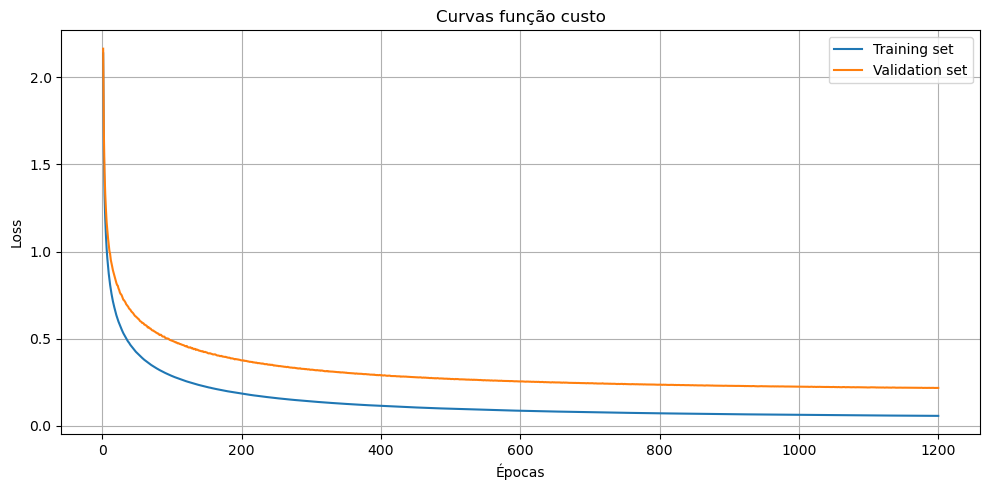

In [48]:
ep, er, er_test = zip(*best_parametros[1])
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curvas função custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Treinei novamente com o melhor modelo

parametros = best_parametros[0] | parametros

model = MLP(
    X_train_standard,
    y_train,
    X_validation_standard,
    y_validation,
    **parametros,
)

model.train()

In [50]:
y_hat = model.predict(X_train_standard)

train_acc = calc_acuracia_global(y_train, y_hat)

In [51]:
y_hat = model.predict(X_validation_standard)

validation_acc = calc_acuracia_global(y_validation, y_hat)

In [52]:
y_hat = model.predict(X_test_standard)

teste_acc = calc_acuracia_global(y_test, y_hat)
teste_matrix = matriz_confusao(y_test, y_hat)

In [53]:
print("Resultados do Treino")
print(f"Acurácia: {train_acc:.2f}\n") 

# Apesar de o modelo ter atingido 100% de acurácia no conjunto de treinamento, isso não parece indicar overfitting, 
# já que os desempenhos nos conjuntos de validação (92%) e teste (91%) também foram altos.

print("Resultados da Validação")
print(f"Acurácia: {validation_acc:.2f}\n")

print("Resultados do Teste")
print(f"Acurácia: {teste_acc:.2f}")
print("Matriz de confusão:")
print(f"{teste_matrix}\n") 

Resultados do Treino
Acurácia: 1.00

Resultados da Validação
Acurácia: 0.92

Resultados do Teste
Acurácia: 0.91
Matriz de confusão:
[[18  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  0]
 [ 0  1  0 17  0  0  0  0  0  0  0]
 [ 0  1  1  0 12  0  0  0  0  1  3]
 [ 1  0  0  0  0 17  0  0  0  0  0]
 [ 2  0  0  0  0  0 13  2  1  0  0]
 [ 0  0  0  0  1  0  1 16  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  1]
 [ 0  0  0  1  0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  0  0  0  0 18]]

